# Unsupervised Learning Trading Strategy

In [2]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [4]:
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

In [9]:
end_date = '2023-12-31'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)
df = yf.download(tickers = symbols_list, start = start_date, end = end_date).stack()
df

[*********************100%%**********************]  503 of 503 completed


Adj Close       Close        High         Low        Open  \
Date                                                                          
2016-01-04 A      38.134430   40.689999   41.189999   40.340000   41.060001   
           AAL    39.095463   40.910000   41.349998   40.299999   41.290001   
           AAPL   23.977476   26.337500   26.342501   25.500000   25.652500   
           ABBV   40.778084   57.610001   58.320000   56.400002   58.060001   
           ABT    36.956310   42.930000   44.049999   42.500000   43.939999   
...                     ...         ...         ...         ...         ...   
2023-12-29 YUM   130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH   121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA  273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION   43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS   197.369995  197.369995  198.009995  196.250000  196.679993   

                      Volume  
Date                          
2016-01-04 A       3287300.0  
           AAL    12037200.0  
           AAPL  270597600.0  
           ABBV   10308400.0  
           ABT    12227500.0  
...                      ...  
2023-12-29 YUM     1196800.0  
           ZBH      849600.0  
           ZBRA     251300.0  
           ZION    1420600.0  
           ZTS     1007200.0  

[994508 rows x 6 columns]

In [10]:
df.index.anmes = ['date', 'ticker']
df.columns = df.columns.str.lower()
df

adj close       close        high         low        open  \
Date                                                                          
2016-01-04 A      38.134430   40.689999   41.189999   40.340000   41.060001   
           AAL    39.095463   40.910000   41.349998   40.299999   41.290001   
           AAPL   23.977476   26.337500   26.342501   25.500000   25.652500   
           ABBV   40.778084   57.610001   58.320000   56.400002   58.060001   
           ABT    36.956310   42.930000   44.049999   42.500000   43.939999   
...                     ...         ...         ...         ...         ...   
2023-12-29 YUM   130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH   121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA  273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION   43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS   197.369995  197.369995  198.009995  196.250000  196.679993   

                      volume  
Date                          
2016-01-04 A       3287300.0  
           AAL    12037200.0  
           AAPL  270597600.0  
           ABBV   10308400.0  
           ABT    12227500.0  
...                      ...  
2023-12-29 YUM     1196800.0  
           ZBH      849600.0  
           ZBRA     251300.0  
           ZION    1420600.0  
           ZTS     1007200.0  

[994508 rows x 6 columns]

## Calculating features and technical indicators for each stock

In [15]:
# Garman-Klass Volatility
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)
df

adj close       close        high         low        open  \
Date                                                                          
2016-01-04 A      38.134430   40.689999   41.189999   40.340000   41.060001   
           AAL    39.095463   40.910000   41.349998   40.299999   41.290001   
           AAPL   23.977476   26.337500   26.342501   25.500000   25.652500   
           ABBV   40.778084   57.610001   58.320000   56.400002   58.060001   
           ABT    36.956310   42.930000   44.049999   42.500000   43.939999   
...                     ...         ...         ...         ...         ...   
2023-12-29 YUM   130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH   121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA  273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION   43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS   197.369995  197.369995  198.009995  196.250000  196.679993   

                      volume  garman_klass_vol  
Date                                            
2016-01-04 A       3287300.0         -0.001893  
           AAL    12037200.0         -0.000821  
           AAPL  270597600.0         -0.001233  
           ABBV   10308400.0         -0.047666  
           ABT    12227500.0         -0.010932  
...                      ...               ...  
2023-12-29 YUM     1196800.0          0.000030  
           ZBH      849600.0          0.000044  
           ZBRA     251300.0          0.000073  
           ZION    1420600.0          0.000102  
           ZTS     1007200.0          0.000035  

[994508 rows x 7 columns]

In [17]:
# RSI
df['rsi'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.rsi(close = x, length = 20))
df

adj close       close        high         low        open  \
Date                                                                          
2016-01-04 A      38.134430   40.689999   41.189999   40.340000   41.060001   
           AAL    39.095463   40.910000   41.349998   40.299999   41.290001   
           AAPL   23.977476   26.337500   26.342501   25.500000   25.652500   
           ABBV   40.778084   57.610001   58.320000   56.400002   58.060001   
           ABT    36.956310   42.930000   44.049999   42.500000   43.939999   
...                     ...         ...         ...         ...         ...   
2023-12-29 YUM   130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH   121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA  273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION   43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS   197.369995  197.369995  198.009995  196.250000  196.679993   

                      volume  garman_klass_vol        rsi  
Date                                                       
2016-01-04 A       3287300.0         -0.001893        NaN  
           AAL    12037200.0         -0.000821        NaN  
           AAPL  270597600.0         -0.001233        NaN  
           ABBV   10308400.0         -0.047666        NaN  
           ABT    12227500.0         -0.010932        NaN  
...                      ...               ...        ...  
2023-12-29 YUM     1196800.0          0.000030  59.338371  
           ZBH      849600.0          0.000044  68.767246  
           ZBRA     251300.0          0.000073  67.914673  
           ZION    1420600.0          0.000102  62.879829  
           ZTS     1007200.0          0.000035  66.791335  

[994508 rows x 8 columns]

<Axes: xlabel='Date'>

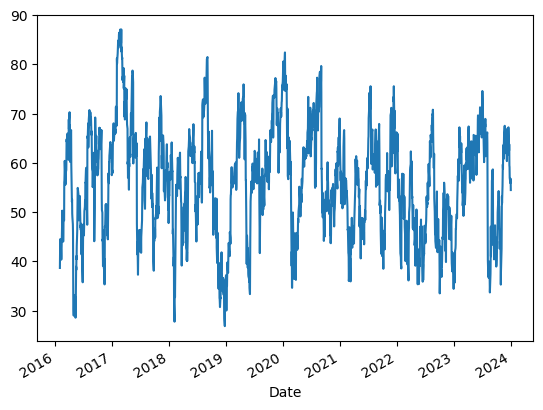

In [19]:
df.xs('AAPL', level = 1)['rsi'].plot()

In [21]:
# Bollinger Bands
df['bb_low'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,0])
df['bb_mid'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,1])
df['bb_high'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,2])
df

adj close       close        high         low        open  \
Date                                                                          
2016-01-04 A      38.134430   40.689999   41.189999   40.340000   41.060001   
           AAL    39.095463   40.910000   41.349998   40.299999   41.290001   
           AAPL   23.977476   26.337500   26.342501   25.500000   25.652500   
           ABBV   40.778084   57.610001   58.320000   56.400002   58.060001   
           ABT    36.956310   42.930000   44.049999   42.500000   43.939999   
...                     ...         ...         ...         ...         ...   
2023-12-29 YUM   130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH   121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA  273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION   43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS   197.369995  197.369995  198.009995  196.250000  196.679993   

                      volume  garman_klass_vol        rsi    bb_low    bb_mid  \
Date                                                                            
2016-01-04 A       3287300.0         -0.001893        NaN       NaN       NaN   
           AAL    12037200.0         -0.000821        NaN       NaN       NaN   
           AAPL  270597600.0         -0.001233        NaN       NaN       NaN   
           ABBV   10308400.0         -0.047666        NaN       NaN       NaN   
           ABT    12227500.0         -0.010932        NaN       NaN       NaN   
...                      ...               ...        ...       ...       ...   
2023-12-29 YUM     1196800.0          0.000030  59.338371  4.824633  4.862793   
           ZBH      849600.0          0.000044  68.767246  4.753563  4.784470   
           ZBRA     251300.0          0.000073  67.914673  5.415905  5.546306   
           ZION    1420600.0          0.000102  62.879829  3.611585  3.749483   
           ZTS     1007200.0          0.000035  66.791335  5.186448  5.259449   

                  bb_high  
Date                       
2016-01-04 A          NaN  
           AAL        NaN  
           AAPL       NaN  
           ABBV       NaN  
           ABT        NaN  
...                   ...  
2023-12-29 YUM   4.900952  
           ZBH   4.815377  
           ZBRA  5.676707  
           ZION  3.887381  
           ZTS   5.332449  

[994508 rows x 11 columns]

In [23]:
# ATR
def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'],
                        low = stock_data['low'],
                        close = stock_data['close'],
                        length = 14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level = 1, group_keys = False).apply(compute_atr)
df

adj close       close        high         low        open  \
Date                                                                          
2016-01-04 A      38.134430   40.689999   41.189999   40.340000   41.060001   
           AAL    39.095463   40.910000   41.349998   40.299999   41.290001   
           AAPL   23.977476   26.337500   26.342501   25.500000   25.652500   
           ABBV   40.778084   57.610001   58.320000   56.400002   58.060001   
           ABT    36.956310   42.930000   44.049999   42.500000   43.939999   
...                     ...         ...         ...         ...         ...   
2023-12-29 YUM   130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH   121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA  273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION   43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS   197.369995  197.369995  198.009995  196.250000  196.679993   

                      volume  garman_klass_vol        rsi    bb_low    bb_mid  \
Date                                                                            
2016-01-04 A       3287300.0         -0.001893        NaN       NaN       NaN   
           AAL    12037200.0         -0.000821        NaN       NaN       NaN   
           AAPL  270597600.0         -0.001233        NaN       NaN       NaN   
           ABBV   10308400.0         -0.047666        NaN       NaN       NaN   
           ABT    12227500.0         -0.010932        NaN       NaN       NaN   
...                      ...               ...        ...       ...       ...   
2023-12-29 YUM     1196800.0          0.000030  59.338371  4.824633  4.862793   
           ZBH      849600.0          0.000044  68.767246  4.753563  4.784470   
           ZBRA     251300.0          0.000073  67.914673  5.415905  5.546306   
           ZION    1420600.0          0.000102  62.879829  3.611585  3.749483   
           ZTS     1007200.0          0.000035  66.791335  5.186448  5.259449   

                  bb_high       atr  
Date                                 
2016-01-04 A          NaN       NaN  
           AAL        NaN       NaN  
           AAPL       NaN       NaN  
           ABBV       NaN       NaN  
           ABT        NaN       NaN  
...                   ...       ...  
2023-12-29 YUM   4.900952 -0.073239  
           ZBH   4.815377 -1.054422  
           ZBRA  5.676707 -0.154931  
           ZION  3.887381  0.177122  
           ZTS   5.332449  0.420520  

[994508 rows x 12 columns]

In [25]:
# MACD
def compute_macd(close):
    macd = pandas_ta.macd(close = close, length = 20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level = 1, group_keys = False)['adj close'].apply(compute_macd)
df

adj close       close        high         low        open  \
Date                                                                          
2016-01-04 A      38.134430   40.689999   41.189999   40.340000   41.060001   
           AAL    39.095463   40.910000   41.349998   40.299999   41.290001   
           AAPL   23.977476   26.337500   26.342501   25.500000   25.652500   
           ABBV   40.778084   57.610001   58.320000   56.400002   58.060001   
           ABT    36.956310   42.930000   44.049999   42.500000   43.939999   
...                     ...         ...         ...         ...         ...   
2023-12-29 YUM   130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH   121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA  273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION   43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS   197.369995  197.369995  198.009995  196.250000  196.679993   

                      volume  garman_klass_vol        rsi    bb_low    bb_mid  \
Date                                                                            
2016-01-04 A       3287300.0         -0.001893        NaN       NaN       NaN   
           AAL    12037200.0         -0.000821        NaN       NaN       NaN   
           AAPL  270597600.0         -0.001233        NaN       NaN       NaN   
           ABBV   10308400.0         -0.047666        NaN       NaN       NaN   
           ABT    12227500.0         -0.010932        NaN       NaN       NaN   
...                      ...               ...        ...       ...       ...   
2023-12-29 YUM     1196800.0          0.000030  59.338371  4.824633  4.862793   
           ZBH      849600.0          0.000044  68.767246  4.753563  4.784470   
           ZBRA     251300.0          0.000073  67.914673  5.415905  5.546306   
           ZION    1420600.0          0.000102  62.879829  3.611585  3.749483   
           ZTS     1007200.0          0.000035  66.791335  5.186448  5.259449   

                  bb_high       atr      macd  
Date                                           
2016-01-04 A          NaN       NaN       NaN  
           AAL        NaN       NaN       NaN  
           AAPL       NaN       NaN       NaN  
           ABBV       NaN       NaN       NaN  
           ABT        NaN       NaN       NaN  
...                   ...       ...       ...  
2023-12-29 YUM   4.900952 -0.073239  0.784240  
           ZBH   4.815377 -1.054422  0.973531  
           ZBRA  5.676707 -0.154931  1.577769  
           ZION  3.887381  0.177122  2.099563  
           ZTS   5.332449  0.420520  2.164720  

[994508 rows x 13 columns]

In [27]:
# Dollar Volume
df['dollar_volume'] = (df['adj close'] * df['volume']) / 1e6
df

adj close       close        high         low        open  \
Date                                                                          
2016-01-04 A      38.134430   40.689999   41.189999   40.340000   41.060001   
           AAL    39.095463   40.910000   41.349998   40.299999   41.290001   
           AAPL   23.977476   26.337500   26.342501   25.500000   25.652500   
           ABBV   40.778084   57.610001   58.320000   56.400002   58.060001   
           ABT    36.956310   42.930000   44.049999   42.500000   43.939999   
...                     ...         ...         ...         ...         ...   
2023-12-29 YUM   130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH   121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA  273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION   43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS   197.369995  197.369995  198.009995  196.250000  196.679993   

                      volume  garman_klass_vol        rsi    bb_low    bb_mid  \
Date                                                                            
2016-01-04 A       3287300.0         -0.001893        NaN       NaN       NaN   
           AAL    12037200.0         -0.000821        NaN       NaN       NaN   
           AAPL  270597600.0         -0.001233        NaN       NaN       NaN   
           ABBV   10308400.0         -0.047666        NaN       NaN       NaN   
           ABT    12227500.0         -0.010932        NaN       NaN       NaN   
...                      ...               ...        ...       ...       ...   
2023-12-29 YUM     1196800.0          0.000030  59.338371  4.824633  4.862793   
           ZBH      849600.0          0.000044  68.767246  4.753563  4.784470   
           ZBRA     251300.0          0.000073  67.914673  5.415905  5.546306   
           ZION    1420600.0          0.000102  62.879829  3.611585  3.749483   
           ZTS     1007200.0          0.000035  66.791335  5.186448  5.259449   

                  bb_high       atr      macd  dollar_volume  
Date                                                          
2016-01-04 A          NaN       NaN       NaN     125.359312  
           AAL        NaN       NaN       NaN     470.599905  
           AAPL       NaN       NaN       NaN    6488.247492  
           ABBV       NaN       NaN       NaN     420.356799  
           ABT        NaN       NaN       NaN     451.883284  
...                   ...       ...       ...            ...  
2023-12-29 YUM   4.900952 -0.073239  0.784240     156.373892  
           ZBH   4.815377 -1.054422  0.973531     103.396317  
           ZBRA  5.676707 -0.154931  1.577769      68.687826  
           ZION  3.887381  0.177122  2.099563      62.321720  
           ZTS   5.332449  0.420520  2.164720     198.791059  

[994508 rows x 14 columns]

## Aggregate to monthly level and filter top 150 most liquid stocks for each month